In [1]:
import matplotlib.pyplot as plt

import numpy as np
import sys  
sys.path.append('../main/')
from multi_py.multi import *
from os.path import dirname, join as pjoin
import scipy.io as sio
from scipy.io import readsav
import copy
import pandas as pd
import os
from scipy import integrate
from scipy.signal import argrelextrema



%config InlineBackend.figure_format='svg'
plt.style.use('default')
plt.style.use('../main/multi_py/Bergemann2020.mplstyle')

In [2]:
sys.path.append('/lustre/astro/ngray/External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

## Read in solar spectrum

In [4]:
sav_fname = pjoin('../../data/spectra/1631885174310_iag_sun_Si.sav')
sav_data = readsav(sav_fname)
f = open('../../data/spectra/sun_kpnomu1_6000_8000A.txt')
obs_spec2 = np.loadtxt(fname=f)

# simulation has been run with mus: 1, 0.9, 0.8, 0.6, 0.4, 0.2
# specify the indecies corresponding to these angles in the solar data
sol_mu_ind = [0, 4, 5, 7, 9, 11]

# get the flux(intensity) and wavelengths corresponding to these angles
sol_fluxes = [sav_data['iag_sun'].flux[0][ang] for ang in sol_mu_ind]
sol_lams = [sav_data['iag_sun'].wave[0][ang] for ang in sol_mu_ind]
sol_mus = [sav_data['iag_sun'].mu[0][ang] for ang in sol_mu_ind]

## Read in simulated spectra

In [3]:
def get_lines(thisrun, krs):
    lines = []
    for kr in krs:
        lines.append(thisrun.line[kr])
    return lines 

In [5]:
# major_krs = [286, 299, 427] # 292 and 302 removed - empty gaps; 457 removed - does not appear in the ref paper
major_krs = [286, 299, 427, 292, 302]#, 457]

# runfiles = ['runs/Si_marcs_LTE_mus/output/', 'runs/Si_stag_NLTE_5x5x230_mus/output/']
NLTE3Drunfile = '../runs/SiStagNLTE_30_f3Dold/output/'
# NLTE3Drunfile = '../runs/iosmet_runs/SiStagNLTE30_full3D/output/'
# NLTE3Drunfile = '../runs/SiMarcs1DNLTE/output/'


# runobjects = [m3d(thisrun, lines=major_krs, conts=[]) for thisrun in runfiles]
# linesobj = [get_lines(thisrunobj, major_krs) for thisrunobj in runobjects]

NLTE3Drunobj = m3d(NLTE3Drunfile, lines=major_krs, conts=[])
NLTE3Dlines = get_lines(NLTE3Drunobj, major_krs)

LTE_runs = '../runs/Si_marcs_LTE_dir/'
# LTE_runs = '../runs/iosmet_runs/SiMarcsLTEdir/'

LTE1d_cog = CoG(runs=LTE_runs, lines=major_krs)

Completed reading parameters from ../runs/Si_marcs_LTE_dir//7.76//output//


In [12]:
wavelengths = [line.lam0 for line in NLTE3Dlines]
# m3d_centre_wavelengths = [5645.613, 5772.146, 7034.901]
m3d_centre_wavelengths = [5645.613, 5684.484, 5701.104, 5772.146, 7034.901]


In [24]:
loggf_atom = [-2.067, -1.42, -2.05, -1.75, -3.714]
loggf_ama = [-2.04, -1.55, -1.95, -1.65, -0.78]
pd.DataFrame(data=list(zip(loggf_atom, loggf_ama)), columns=[ 'log gf atom file', 'log gf Amarsi 2017'], index=m3d_centre_wavelengths)

,log gf atom file,log gf Amarsi 2017
5645.613,-2.067,-2.04
5684.484,-1.420,-1.55
5701.104,-2.050,-1.95
5772.146,-1.750,-1.65
7034.901,-3.714,-0.78


## Plot COG

In [7]:
def get_abnds_corr(cogobj, NLTErun, kr, qmax):
    all_corrs =  [(cogobj.abnds_corr(NLTE=NLTErun, kr=kr, qmax=qmax, ang=ang)).item() for ang in range((4*len(sol_mus[1:])+1))]
    # print(all_corrs)
    kr_corrs = [all_corrs[0]]
    # print(kr_corrs)
    for mu, _ in enumerate(sol_mus[1:]):
        ang_start = mu*4+1
        ang_end = ang_start+4
        kr_corrs.append(np.mean(all_corrs[ang_start:ang_end]))
        # print(f'{all_corrs[ang_start]}:{all_corrs[ang_end-1]}')
    return kr_corrs

In [8]:
def get_cog_eqw(cogobj, kr, qmax):
    all_eqws =  [cogobj.calc_weq(kr=kr, qmax=qmax, ang=ang, norm=True) for ang in range((4*len(sol_mus[1:])+1))]
    # print(all_eqws)
    kr_eqws = [all_eqws[0]]
    # print(kr_eqws)
    for mu, _ in enumerate(sol_mus[1:]):
        ang_start = mu*4+1
        ang_end = ang_start+4
        kr_eqws.append(np.mean(all_eqws[ang_start:ang_end], axis=0))
        # print(f'{ang_start}:{ang_end}')
        # print(f'range-{all_eqws[ang_start]}:{all_eqws[ang_end-1]}')
    return kr_eqws

In [9]:
# get_cog_eqw(LTE1d_cog, major_krs[0], qmax=3.5)

In [10]:
def get_line_eqw(linesobj, line, qmax):
    all_eqws =  [linesobj[line].calc_weq(qmax=qmax, ang=ang, norm=True) for ang in range((4*len(sol_mus[1:])+1))]
    line_eqws = [all_eqws[0]]
    for mu, _ in enumerate(sol_mus[1:]):
        ang_start = mu*4+1
        ang_end = ang_start+4
        line_eqws.append(np.mean(all_eqws[ang_start:ang_end]))
        # print(f'{all_corrs[ang_start]}:{all_corrs[ang_end-1]}')
    return line_eqws

In [11]:
# NLTE_obj = runobjects[1]
# corrections = np.array([[LTE1d_cog.abnds_corr(NLTE3Drunobj, kr=thiskr, qmax=3.5, ang=ang) for ang in range(len(sol_mus))] for thiskr in major_krs])
corrections = np.array([get_abnds_corr(cogobj=LTE1d_cog, NLTErun=NLTE3Drunobj, kr=thiskr, qmax=3.5) for thiskr in major_krs])
# eqwidths_1dlte = np.array([[LTE1d_cog.calc_weq(kr=kr, ang=ang, qmax=3.5, norm=True) for ang in range(len(sol_mus))] for kr in major_krs])
eqwidths_1dlte = np.array([get_cog_eqw(cogobj=LTE1d_cog, kr=thiskr, qmax=3.5) for thiskr in major_krs])
# eqw_NLTE = [[NLTE3Dlines[line].calc_weq(ang=ang, qmax=3.5, norm=True) for ang in range(len(sol_mus))] for line in range(len((NLTE3Dlines)))]
eqw_NLTE = [get_line_eqw(linesobj=NLTE3Dlines, line=thisline, qmax=3.5) for thisline in range(len((NLTE3Dlines)))]

d = { 'Wavelengths': wavelengths,
      'Abundance_cor': corrections,

}

In [12]:
eqwidths_1dlte.shape

(5, 6, 9)

In [13]:
def ax_text(i,j, ax, posx, posy, color='k'):
    
    d = {'3D NLTE Ab. cor.:': np.round(corrections[i,j],4)
        }
    
    add_text_to_ax(posx, posy, nice_string_output(d), ax, fontsize=8, color=color)
    return None

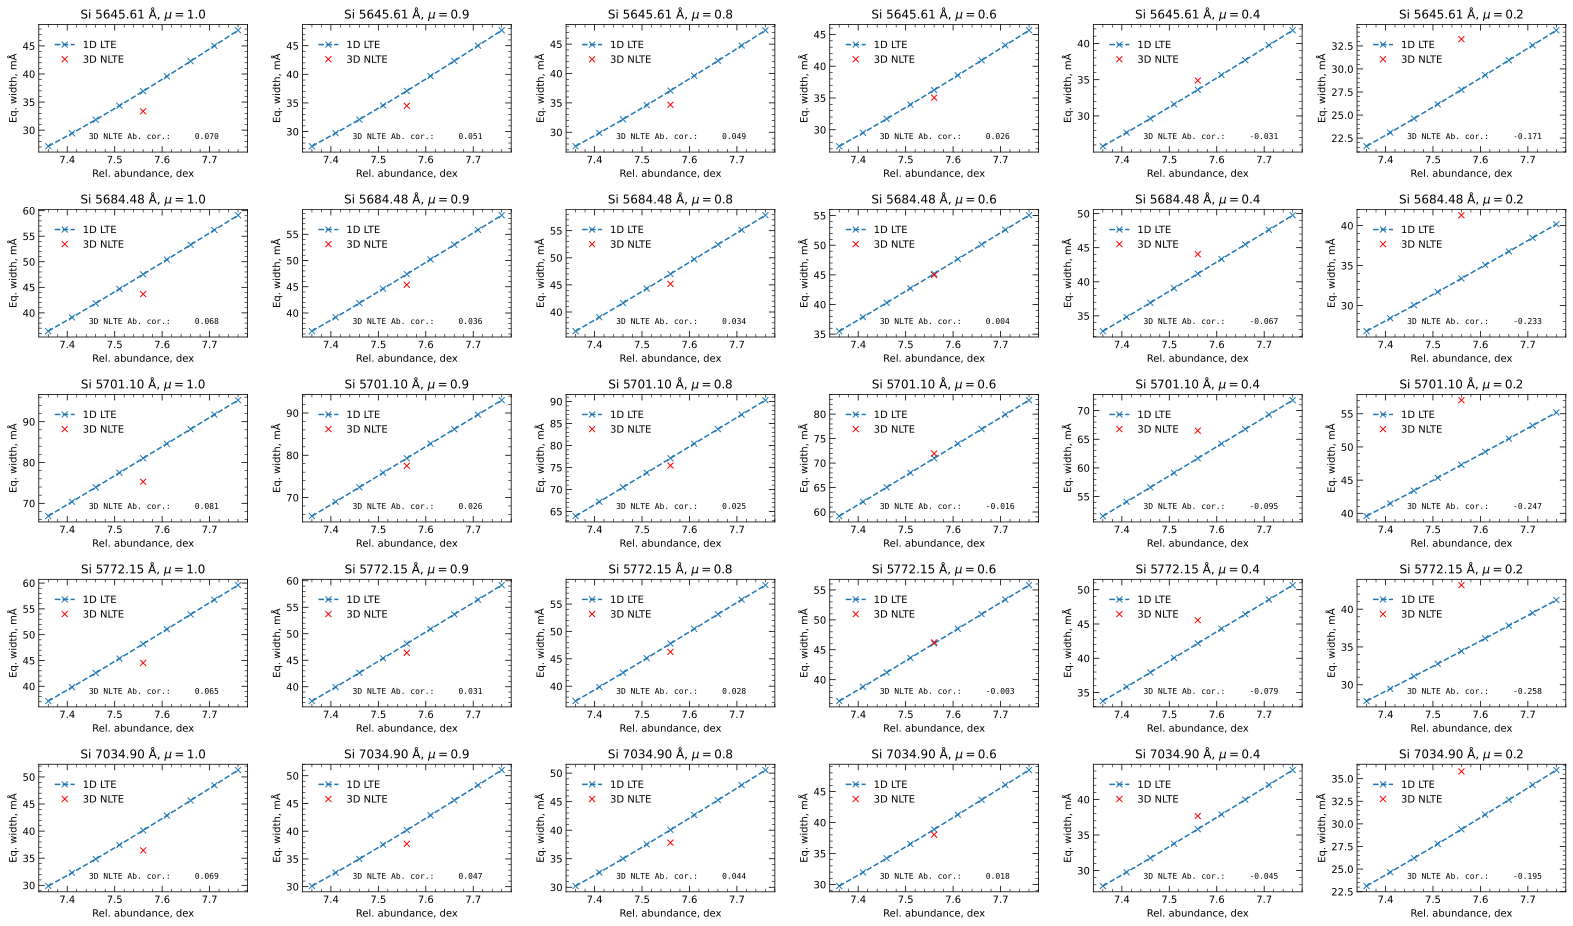

In [14]:
fig_ew, ax_ew = plt.subplots(len(major_krs), len(sol_mus), figsize=(22,13))

abundances = LTE1d_cog.abnds

for i, kr in enumerate(major_krs):
    for j, mu in enumerate(sol_mus):
        ax_ew[i,j].plot(LTE1d_cog.abnds, eqwidths_1dlte[i,j], '--x', label='1D LTE')
        ax_ew[i,j].plot(NLTE3Drunobj.abnd, eqw_NLTE[i][j], 'rx', label='3D NLTE')
        ax_ew[i,j].set_title(f'Si {m3d_centre_wavelengths[i]:.2f} Å, $\mu = {sol_mus[j]:.1f}$')
        ax_ew[i,j].set_ylabel('Eq. width, mÅ')
        ax_ew[i,j].set_xlabel('Rel. abundance, dex')
        ax_text(i,j, ax_ew[i,j],  0.24, 0.15)
        
        # ax_ew[i,j].grid(which='both')

        ax_ew[i,j].legend()

plt.tight_layout()
# fig_ew.savefig('../plots/3dabundcorr_IOSMET_5wls.pdf')

In [19]:
# np.save('../mdata/3DNLTE_eqs_30f3D_noiosmet_5wl', eqw_NLTE)
# np.save('../mdata/1DNLTE_abund_corr_no_iosmet__5wls', corrections)

In [16]:
np.shape(eqw_NLTE)

(5, 6)

In [17]:
eqw_NLTE[0]

[33.35901899120127,
 34.49561699779338,
 34.679474983436364,
 35.051065956723875,
 34.880610304497,
 33.23576090409628]

In [18]:
sol_mus

[1.0, 0.9, 0.8, 0.6, 0.4, 0.2]